In [2]:
# packages to import: xmitgcm, matplotlib, numpy, os, sys, ecco_v4_py, pandas, warnings, pyTMD (remember to install it!), datetime, xarray
from xmitgcm import open_mdsdataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from os.path import expanduser,join,isdir
import sys
user_home_dir = expanduser('~')
ecco_v4_py_dir = join(user_home_dir,'ECCOv4-py')
if isdir(ecco_v4_py_dir):
    sys.path.insert(0,ecco_v4_py_dir)
from ecco_v4_py import plot_proj_to_latlon_grid
import ecco_v4_py as ecco
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import pyTMD.crs
import pyTMD.io
import pyTMD.tools
from pyTMD.solve import constants
from datetime import datetime, timedelta
import pyTMD
import xarray as xr

# OUR RUN

In [5]:
data_dir ='/efs_ecco/hvanderz/export_tides' # directory where your files for the run with tides are
grid_dir ='/efs_ecco/hvanderz/r5/WORKINGDIR/ECCOV4/release5_ToTs/run' # directory where your grid is
ds_llc = open_mdsdataset(data_dir, 
                        grid_dir=grid_dir, 
                         prefix={'ETAN'},
                         geometry="llc") 

ds_llc = ds_llc.rename({'face':'tile'}) # to use ecco_v4_py routines you need to rename face to tile

In [4]:
data_dir ='/efs_ecco/hvanderz/export_notide' # directory where your files for the run with NO tides are (the grid should be the same as tides run)
ds_notide = open_mdsdataset(data_dir, 
                        grid_dir=grid_dir, 
                         prefix={'ETAN'},
                         geometry="llc") 

ds_notide = ds_notide.rename({'face':'tile'}) # to use ecco_v4_py routines you need to rename face to tile

In [6]:
# conversion of date format to datetime (remember to consider the TRUE time of start of your run, so the time of the first saved output)
ds_notide['time'] = xr.cftime_range(start='1992-01-01T13:00:00', periods=ds_notide.dims['time'], freq='h') 
ds_llc['time'] = xr.cftime_range(start='1992-01-01T13:00:00', periods=ds_llc.dims['time'], freq='h')

In [7]:
# to compute anomalies you need to have all as a single chunk, so unify them
ds_llc = ds_llc.unify_chunks()
ds_notide = ds_notide.unify_chunks()

In [8]:
# compute of anomalies. You can do them with two different averages: long run mean or monthly mean
ds_clm = ds_llc.groupby('time.month').mean('time') # monthly mean
#ds_clm = ds_llc.mean('time') # long run mean
ds_llc_anom = ds_llc.groupby('time.month') - ds_clm # monthly mean
#ds_llc_anom = ds_llc - ds_clm # long run mean

ds_clm_notide = ds_notide.groupby('time.month').mean('time')
#ds_clm = ds_llc.mean('time')
ds_notide_anom = ds_notide.groupby('time.month') - ds_clm_notide
#ds_llc_anom = ds_llc - ds_clm

# pyTMD

In [9]:
# creation of a time vector with correct number of time points, start time and frequency
n_files = len(ds_llc_anom.time) # number of time points        
start_time = '1992-01-01 13:00:00' # start of the saved output
freq = 'h' # frequency
time_eta = pd.date_range(start=start_time, periods=n_files, freq=freq) # time vector

In [10]:
# pyTMD requires as input the number of days from january 1st 1992
epoch = datetime(1992, 1, 1, 0, 0, 0) 
t = np.array([(ti.to_pydatetime() - epoch).total_seconds() / 86400.0 for ti in time_eta])

In [11]:
# selection of the point for the analysis
ht_mod = ds_llc_anom.isel(tile=4, i=45, j=45).ETAN.values

In [12]:
# selection of the components you want to study
constituents = ['m2', 's2', 'n2', 'k2','k1', 'o1', 'p1', 'q1', 'mm', 'mf', 'm4', 'mn4', 'ms4', '2n2']

In [13]:
# calculation of amplitude and phase of tides from our run using pyTMD. The function requires a vector of time given as days from 01/01/1992, the 
# elevation field you want to fit and the constituents you want to fit
amp_fit, phase_fit = constants(
    t=t,
    ht=ht_mod,
    constituents=constituents,
    deltat=0.0,
    corrections='OTIS',
    solver='lstsq'
)

In [14]:
# computation of harmonic constants using the amplitude and phase obtained before (remember that phase needs to be in rads)
ph_rad = np.deg2rad(phase_fit)
hc = amp_fit * np.exp(-1j * ph_rad)

In [15]:
# Given harmonic constants we create a timeseries, which is a prediction of tides fitted on our original timeseries. The function requires the same
# inputs as before
ht_fit = pyTMD.predict.time_series(
    t=t,
    hc=hc,
    constituents=constituents,
    deltat=0.0,               
    corrections='OTIS'
)

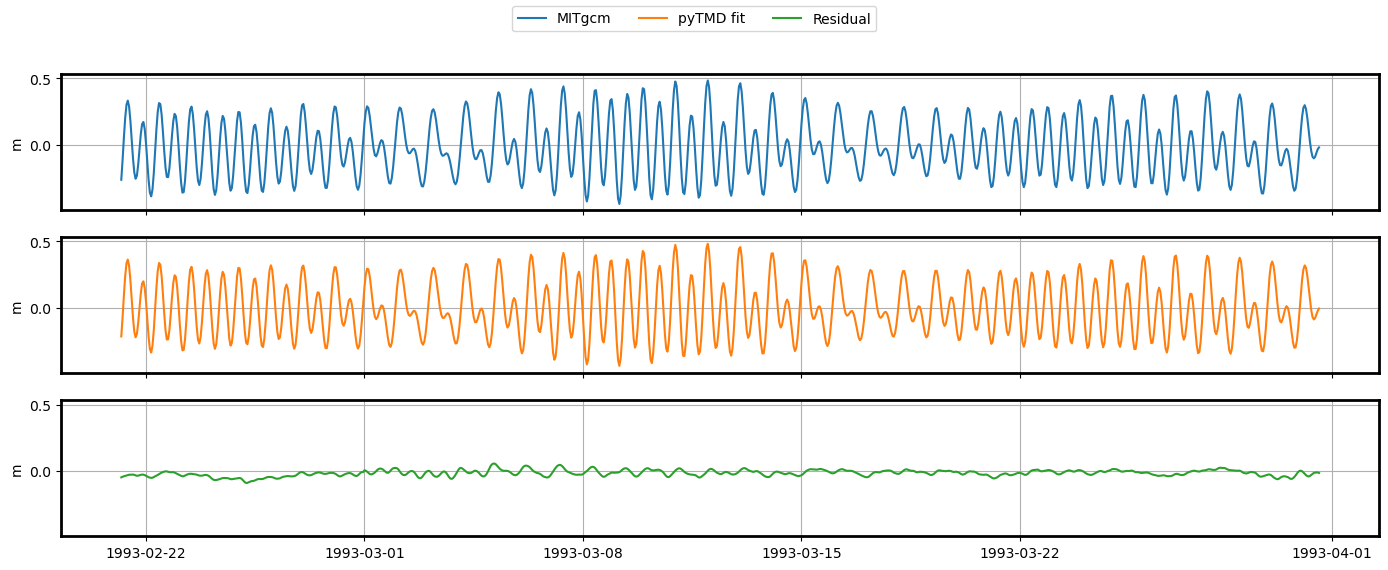

In [16]:
# plot for comparing our run, the fit of tides and the residual part (simple difference between the first two)
# I have selected a shorter period to plot so that data can be easily compared, depending on the time you use they can change
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(time_eta[10000:11000],  ht_mod[10000:11000], label="MITgcm", color="C0")
ax1.plot(time_eta[10000:11000], ht_fit[10000:11000], label="pyTMD fit", color="C1")
ax2.plot(time_eta[10000:11000],  ht_mod[10000:11000] - ht_fit[10000:11000], label="Residual", color="C2")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()

# TPXO

In [17]:
# pyTMD permits you to interact directly to choose the correct directory in which files of a certain tide model are present. pyTMD supports a lot of 
# different tide models (see https://pytmd.readthedocs.io/en/latest/ for reference). You can also directly put in the model function all the information it
# obtains from the interaction. In our case we are using TPXO data
model_list = sorted(pyTMD.io.model.ocean_elevation())
TMDwidgets = pyTMD.tools.widgets()
TMDwidgets.model.options = model_list
TMDwidgets.model.value = 'TPXO9.1'
TMDwidgets.VBox([
    TMDwidgets.directory,
    TMDwidgets.model,
    TMDwidgets.compress
])
# our directory is /efs_ecco/hvanderz/TMD

In [18]:
# remember that TPXO data always start at 01/01/1992 at midnight 
n_files = len(ds_llc_anom.time)              
start_time_tpxo = '1992-01-01 00:00:00'    
freq = 'h'                  
time_eta_tpxo = pd.date_range(start=start_time_tpxo, periods=n_files, freq=freq)

In [19]:
epoch_tpxo = datetime(1992, 1, 1, 0, 0, 0)
t_tpxo = np.array([(ti.to_pydatetime() - epoch_tpxo).total_seconds() / 86400.0 for ti in time_eta_tpxo])

In [20]:
# get model parameters (here is where you put directly the information extracted by the widgets if you want)
model = pyTMD.io.model(TMDwidgets.directory.value,
    compressed=TMDwidgets.compress.value
   ).elevation(TMDwidgets.model.value)

In [21]:
# evaluation of amplitude, phase, bathimetry and constitutions from the model you have provided. The function requires longitude, latitude, a grid
# file, a model file, a particular projection, which variable you want to study and a method to interpolate
amp,ph,D,c = pyTMD.io.OTIS.extract_constants(97.5, -23.85, model.grid_file, model.model_file, 4326,
    type='z',
    method='spline',
    grid='OTIS')

In [22]:
ph_rad = np.deg2rad(ph)
hc = amp * np.exp(-1j * ph_rad)

In [23]:
ht = pyTMD.predict.time_series(
    t=t_tpxo,
    hc=hc,
    constituents=constituents,
    deltat=0.0,               
    corrections=model.format
    #epoch = epoch_tpxo
)

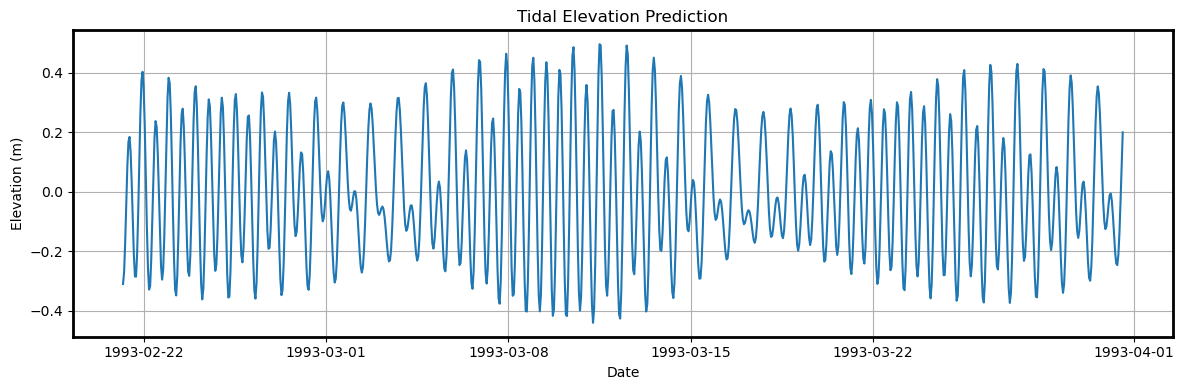

In [24]:
# plot of TPXO tidal prediction
plt.figure(figsize=(12, 4))
plt.plot(time_eta[10000:11000], ht[10000:11000])
plt.title("Tidal Elevation Prediction")
plt.xlabel("Date")
plt.ylabel("Elevation (m)")
plt.grid(True)
plt.tight_layout()
plt.show()

# COMPARISON

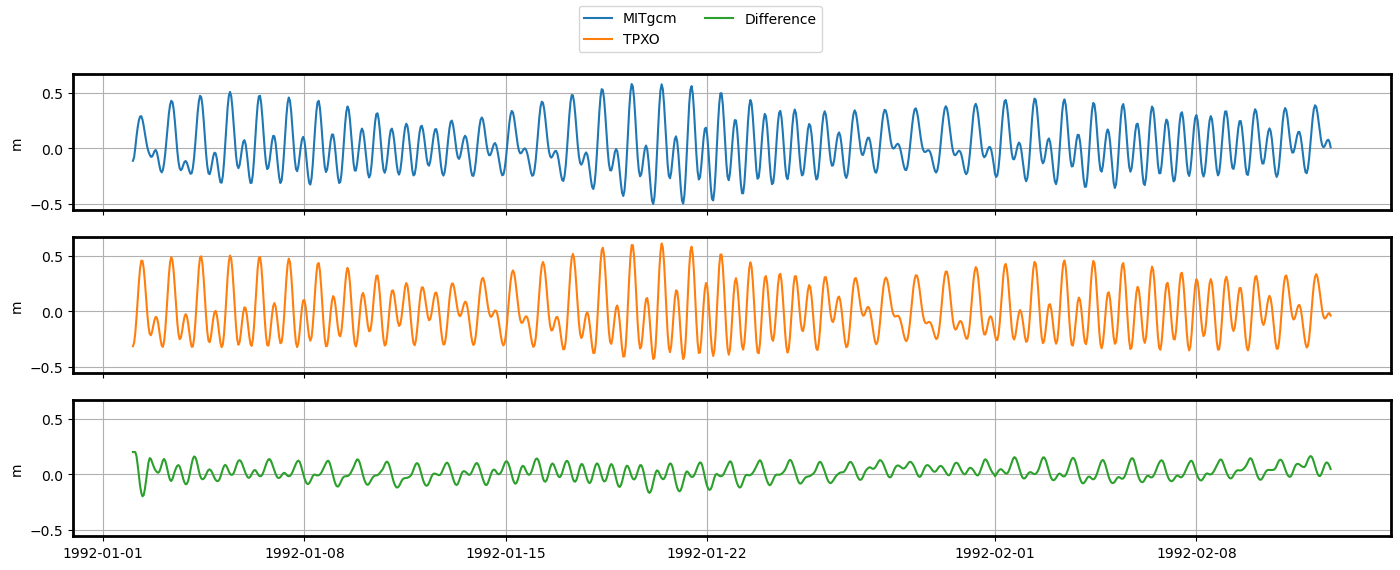

In [25]:
# comparison of our run and TPXO. Remember that if they have a different starting time you need to adapt the times at which you are plotting them
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(time_eta[12:1012],  ht_mod[12:1012], label="MITgcm", color="C0")
ax1.plot(time_eta_tpxo[25:1025], ht[25:1025], label="TPXO", color="C1")
ax2.plot(time_eta[12:1012], ht_mod[12:1012]-ht[25:1025], label="Difference", color="C2")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=2, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()

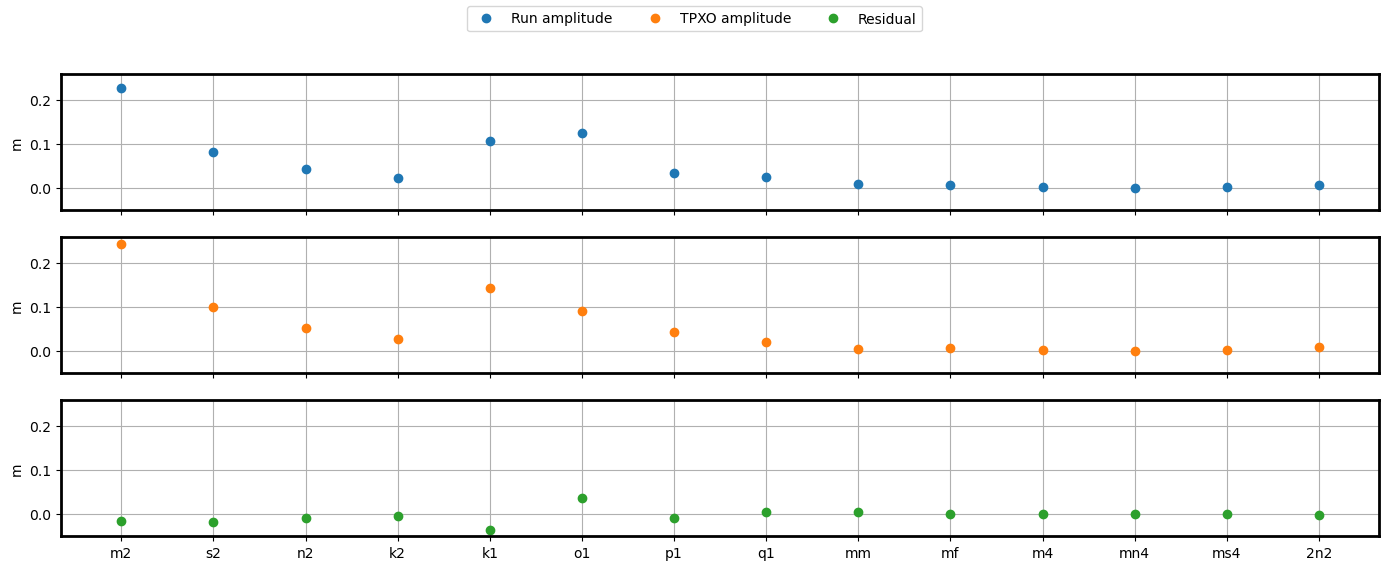

In [26]:
# comparison of amplitudes of consituents 
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(constituents, amp_fit, label="Run amplitude", color="C0", marker = "o", linestyle = "None")
ax1.plot(constituents, amp.data[0][:14], label="TPXO amplitude", color="C1", marker = "o", linestyle = "None")
ax2.plot(constituents,  amp_fit - amp.data[0][:14], label="Residual", color="C2", marker = "o", linestyle = "None")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()

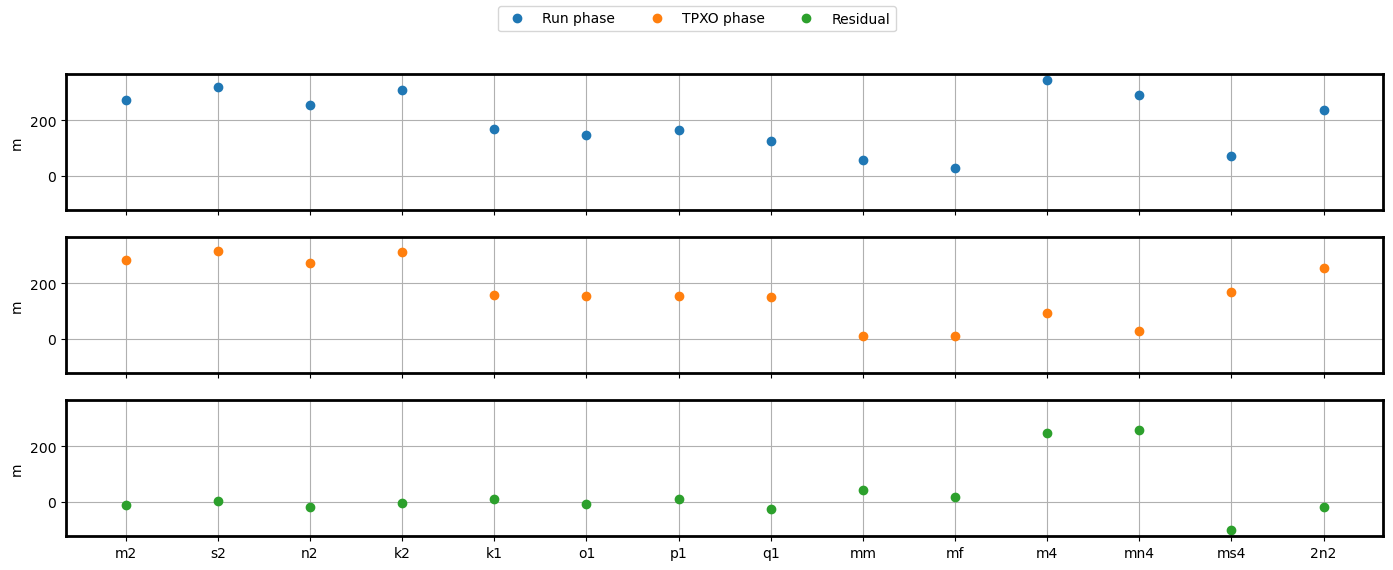

In [27]:
# comparison of phases of constituents
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(constituents,  phase_fit, label="Run phase", color="C0", marker = "o", linestyle = "None")
ax1.plot(constituents, ph.data[0][:14], label="TPXO phase", color="C1", marker = "o", linestyle = "None")
ax2.plot(constituents,  phase_fit - ph.data[0][:14], label="Residual", color="C2", marker = "o", linestyle = "None")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()

# COMPARISON ETAN TIDE-NOTIDE

In [32]:
# selection of last year data from run with and without tides (it would be better to use a long run, such as 5 years one)
ds_llc_ly = ds_llc.isel(time = slice(35160, 43920))
ds_notide_ly = ds_notide.isel(time = slice(35160, 43920))

In [35]:
# mean of last year data
ds_mean_ly = ds_llc_ly.mean('time')
ds_notide_mean_ly = ds_notide_ly.mean('time')

In [37]:
# difference of last year data
diff = ds_mean_ly - ds_notide_mean_ly

In [39]:
# resample of our ECCO data on a lat, lon projection at 1 degree resolution
new_grid_delta_lat = 1
new_grid_delta_lon = 1

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180

new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
ds_lat_lon =\
        ecco.resample_to_latlon(diff.XC, \
                                diff.YC, \
                                diff.where(diff.maskC[0]).ETAN,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.nan, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000) 

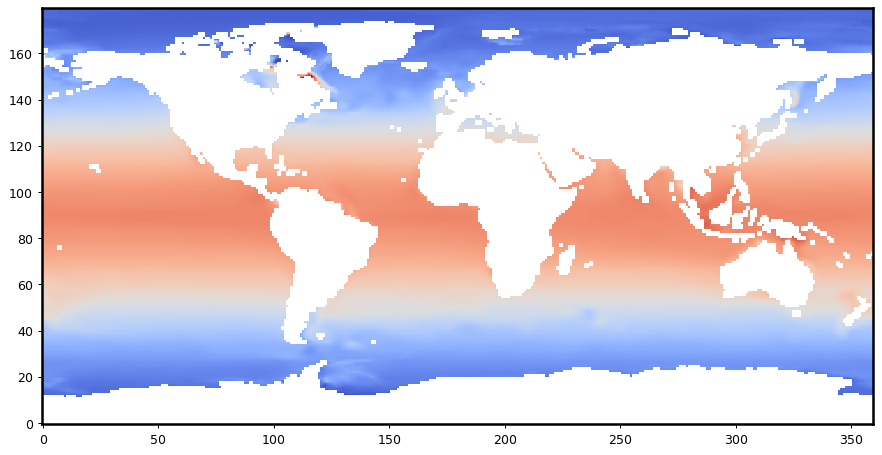

In [44]:
plt.figure(figsize=(12,6), dpi= 90)
plt.imshow(ds_lat_lon,origin='lower', cmap='coolwarm', vmin = -0.15, vmax=0.15)

In [49]:
# selection of last year data from anomalies with and without tides (it would be better to use a long run, such as 5 years one)
ds_anom_llc_ly = ds_llc_anom.isel(time = slice(35160, 43920))
ds_anom_notide_ly = ds_notide_anom.isel(time = slice(35160, 43920))

In [51]:
ds_mean_anom_ly = ds_anom_llc_ly.mean('time')
ds_notide_anom_mean_ly = ds_anom_notide_ly.mean('time')

In [53]:
diff_anom = ds_mean_anom_ly - ds_notide_anom_mean_ly

In [54]:
new_grid_delta_lat = 1
new_grid_delta_lon = 1

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180

new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
ds_lat_lon =\
        ecco.resample_to_latlon(diff_anom.XC, \
                                diff_anom.YC, \
                                diff_anom.where(diff_anom.maskC[0]).ETAN,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.nan, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000) 

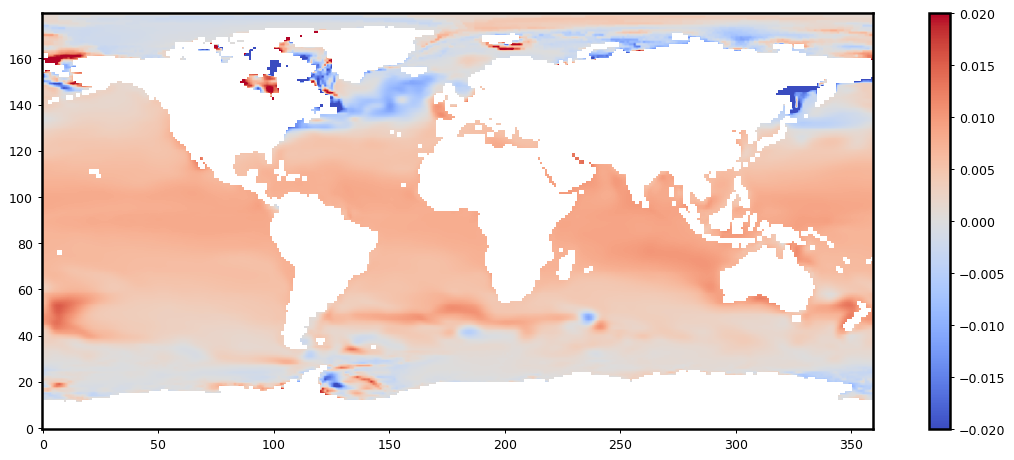

In [61]:
plt.figure(figsize=(16,6), dpi= 90)
plt.imshow(ds_lat_lon,origin='lower', cmap='coolwarm', vmin = -0.02, vmax=0.02)
plt.colorbar()